In [1]:
# libraries
import numpy as np
import pandas as pd

from chronocluster.data.simdata import generate_random_points
from chronocluster import clustering
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, plot_mc_points, get_box, chrono_plot
from chronocluster.distributions import ddelta

In [2]:
# data wrangling
df = pd.read_csv('../Data/temples.csv')
df = df.dropna(subset=['xeast', 'ynorth', 'date'])
df

,id,morph,azimuth,area,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,...,trait_8,name,date,dating_notes,xlong,ylat,date_type,xeast,ynorth,date_emp
0,876,square,90.424247,90.860298,False,False,True,False,True,True,...,False,Unknown,995.0,Date derived from art historical analyses of l...,103.85821,13.42621,empirical,376391.1,1484555.0,995.0
1,874,square,90.000000,121.102386,False,False,False,False,True,True,...,False,Sâk Krâop (Pr.),889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,376029.9,1484559.0,889.0
2,878,square,90.000000,144.909427,False,False,True,False,True,True,...,False,Tuol,889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,376568.1,1484474.0,889.0
3,933,square,90.000000,182.458280,False,False,True,False,False,False,...,False,Top (Pr.),1115.0,Temple is included in the CCC,NaN,NaN,empirical,377453.2,1486464.0,1115.0
4,973,square,90.658658,185.512325,False,False,NaN,NaN,NaN,NaN,...,NaN,Angkor Thom (Laterite slabs and sculpture debris),1002.0,Temple is included in the CCC during Period 3.,NaN,NaN,empirical,377851.6,1486810.0,1002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,6996,NaN,NaN,NaN,NaN,NaN,True,False,True,False,...,False,Unknown,1166.0,Date derived through graph-based semi-supervis...,103.77332,13.37078,graphbased,367166.2,1478474.0,NaN
1388,7001,NaN,NaN,NaN,NaN,NaN,False,False,False,True,...,False,Unknown,848.0,Date derived through graph-based semi-supervis...,103.94124,13.36301,graphbased,385365.8,1477530.0,NaN
1389,7002,NaN,NaN,NaN,NaN,NaN,True,False,False,True,...,False,Unknown,934.0,Date derived through graph-based semi-supervis...,103.89110,13.33931,graphbased,379910.8,1474927.0,NaN
1391,7005,NaN,NaN,NaN,NaN,NaN,True,False,True,False,...,False,Unknown,1166.0,Date derived through graph-based semi-supervis...,103.94205,13.35556,graphbased,385420.9,1476712.0,NaN


In [3]:
points = [
    clustering.Point(
        x=row['xeast'],
        y=row['ynorth'],
        start_distribution = ddelta(row['date']),
        end_distribution = ddelta(1500)
    )
    for _, row in df.iterrows()
]

In [4]:
points

[Point(x=376391.1, y=1484555.0, start_distribution=ddelta(d=995.0), end_distribution=ddelta(d=1500)),
 Point(x=376029.9, y=1484559.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=376568.1, y=1484474.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=377453.2, y=1486464.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=377851.6, y=1486810.0, start_distribution=ddelta(d=1002.0), end_distribution=ddelta(d=1500)),
 Point(x=377220.5, y=1487538.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=377181.0, y=1487114.0, start_distribution=ddelta(d=926.0), end_distribution=ddelta(d=1500)),
 Point(x=377328.8, y=1486122.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=375082.2, y=1487158.0, start_distribution=ddelta(d=926.0), end_distribution=ddelta(d=1500)),
 Point(x=376487.6, y=1484022.0, start_distribution=ddelta(d=958.0), end_distri

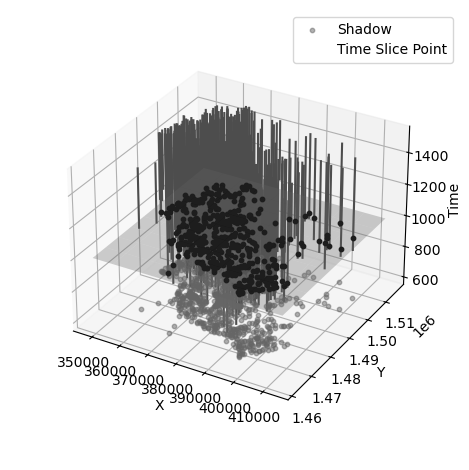

In [5]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=1000)
ax.set_box_aspect(None, zoom=0.85)

In [16]:
# Define the time slices
start_time = 800
end_time = 1200
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)

# Precompute inclusion probabilities based on age models and time slices
inclusion_probs = clustering.in_probs(points, time_slices)

# Run the Monte Carlo simulation to get an ensemble of probable
# lists of points included in each time slice.
num_iterations = 100
simulations = clustering.mc_samples(points,
                                    time_slices,
                                    inclusion_probs,
                                    num_iterations=num_iterations)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations,
                                                         time_slices,
                                                         bw=50,
                                                         density=False,
                                                         max_distance=50000)


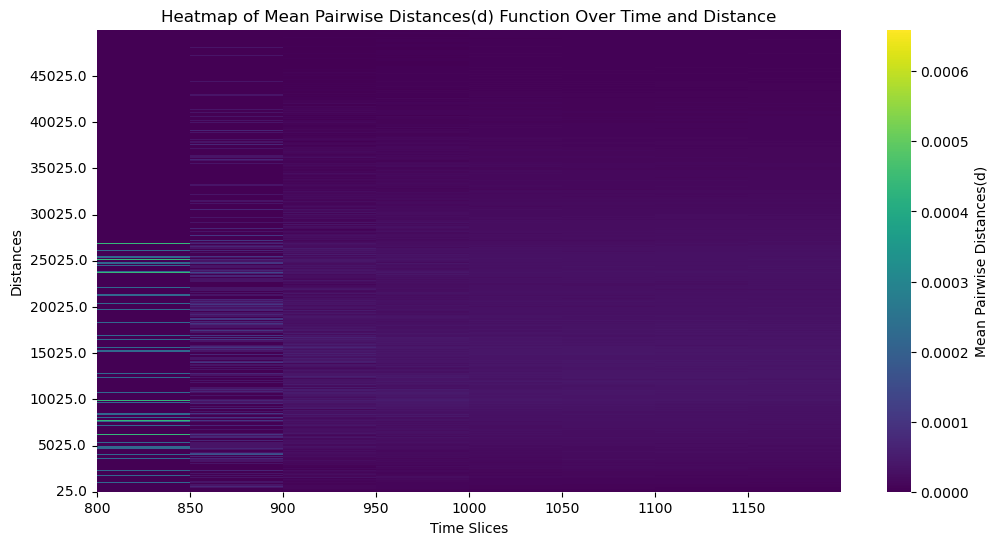

In [17]:
# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

In [18]:
# Generate CSR sample
csr_points = clustering.csr_sample(points, x_min, x_max, y_min, y_max)

# Get CSR inclusion probabilities (remember these points have the same
# temporal traits as the first simulated data)
csr_inclusion_probs = clustering.in_probs(csr_points,
                                          time_slices)

# Get MC iterations for incorporating chronological uncertainty
num_iterations = 100
csr_simulations = clustering.mc_samples(csr_points,
                                        time_slices,
                                        csr_inclusion_probs,
                                        num_iterations = num_iterations)

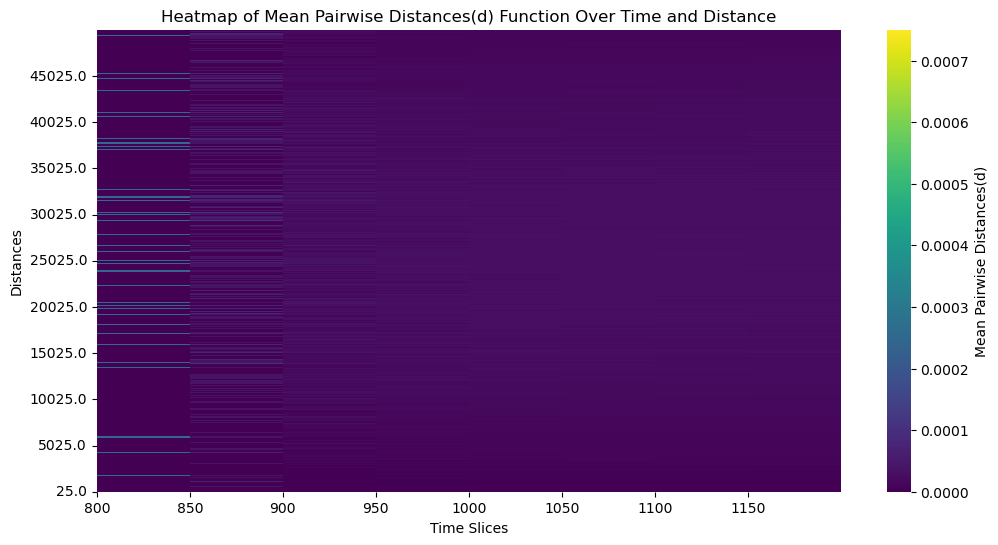

In [20]:
# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations,
                                                                 time_slices,
                                                                 bw = 50,
                                                                 density = False,
                                                                 max_distance = 50000)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

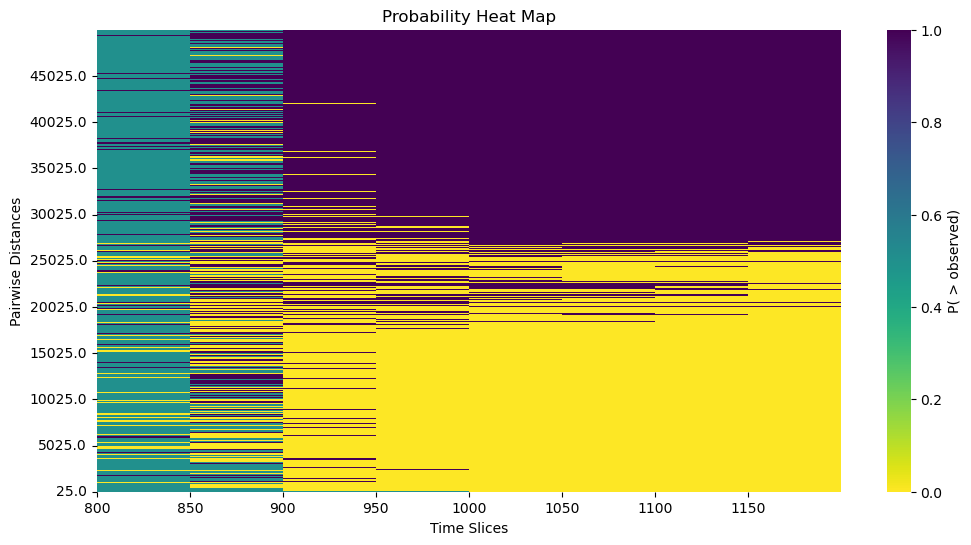

In [21]:
# Calculate the p-values for density differences between the observed points and
# the simulated CSR baseline per distance and temporal slice
p_diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              csr_support)
